## Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.
### Exercise 1: Sentiment Analysis
#### 1.1
Installing Libraries

In [ ]:
!pip install datasets

Loading Dataset

In [6]:
from datasets import load_dataset
dataset_id = "rotten_tomatoes"
# Il dataset Rotten Tomatoes è disponibile con il nome "rotten_tomatoes"
dataset = load_dataset(dataset_id)

In [7]:
print(dataset)  # Dataset split: train, validation, test
# One training example
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


Notes: The split is 80% Train, 10% Validation, 10% Test ✅

Notes: The rock rocks 🗿

In [8]:
# Showing dataset features
print(dataset["train"].features)
# Showing instances per class (label: 0 = ❌, 1 = ✅)
from collections import Counter

labels = [example["label"] for example in dataset["train"]]
print(Counter(labels))


{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
Counter({1: 4265, 0: 4265})


Notes: Dataset is perfectly balanced ✅

### 1.2: Pre-trained BERT
Importing Distilbert tokenizer

In [22]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Visualizing sentences length distribution

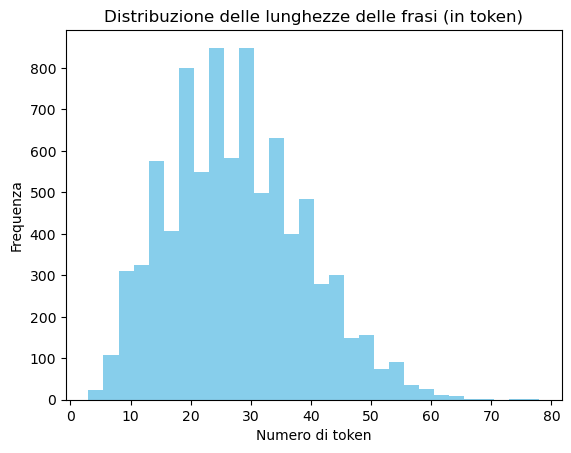

In [10]:
import matplotlib.pyplot as plt
# Calculating length (number of tokens)
lengths = [len(tokenizer(example["text"])["input_ids"]) for example in dataset["train"]]#.select(range(1000))]

# Visualizing sentences length distribution
plt.hist(lengths, bins=30, color="skyblue")
plt.title("Distribuzione delle lunghezze delle frasi (in token)")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.show()


Notes: Length of sentences varies alot

⚠️ Installing PyTorch

In [ ]:
import subprocess
cmd = [
    "pip3", "install",
    "torch", "torchvision", "torchaudio",
    "--index-url", "https://download.pytorch.org/whl/cu118"
]
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line, end='')
process.wait()

⚙️ Checking if PyTorch is correctly installed and CUDA is available

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.7.0+cu118
True


Importing Model

In [14]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_name)

c:\Users\verba\anaconda3\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

c:\Users\verba\anaconda3\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\verba\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_

In [ ]:
# Taking a couple of sentences from the dataset
sample_texts = [dataset["train"][i]["text"] for i in range(2)]

# Tokenization with padding and conversion to tensors
inputs = tokenizer(sample_texts, padding=True, truncation=True, return_tensors="pt")

print("Tokenized input keys:", inputs.keys())
print("Input IDs shape:", inputs["input_ids"].shape)


Tokenized input keys: dict_keys(['input_ids', 'attention_mask'])
Input IDs shape: torch.Size([2, 52])


In [19]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

# outputs è un oggetto di tipo BaseModelOutput, contiene 'last_hidden_state'
print("Output keys:", outputs.keys())
print("Last hidden state shape:", outputs.last_hidden_state.shape)
tokenizer.decode(inputs['input_ids'][0])

Output keys: odict_keys(['last_hidden_state'])
Last hidden state shape: torch.Size([2, 52, 768])


'[CLS] the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

Notes: The first token is [CLS], which codifies informations about the sentence and will be used for feature extraction

### 1.3 Stable Baseline

#### 1.3.A: Feature Extraction
We will use Distilbert to extract the features from the [CLS] token

🛠️ Definition of Extraction function:

In [28]:
import os
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from tqdm import tqdm

def extract_and_save_features(dataset_split, split_name, model, tokenizer, batch_size=32, save_dir="features"):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{split_name}_features.npz")

    if os.path.exists(save_path):
        print(f"Loading from cache: {save_path}")
        data = np.load(save_path)
        return data["features"], data["labels"]

    dataloader = DataLoader(dataset_split, batch_size=batch_size)
    all_features = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Extraction {split_name}"):
            texts = batch["text"]
            labels = batch["label"]

            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # batch_size x hidden_size

            all_features.append(cls_embeddings)
            all_labels.extend(labels)

    features = np.concatenate(all_features)
    labels = np.array(all_labels)

    np.savez(save_path, features=features, labels=labels)
    print(f"Salvato in {save_path}")
    return features, labels



▶️ Feature Extraction

In [27]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

X_train, y_train = extract_and_save_features(dataset["train"], "train", model, tokenizer)
X_val, y_val = extract_and_save_features(dataset["validation"], "val", model, tokenizer)
X_test, y_test = extract_and_save_features(dataset["test"], "test", model, tokenizer)


c:\Users\verba\anaconda3\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassi

Salvato in features\train_features.npz


Estrazione val: 100%|██████████| 34/34 [00:23<00:00,  1.43it/s]


Salvato in features\val_features.npz


Estrazione test: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]

Salvato in features\test_features.npz


#### 1.3.B: Training a Classifier

🛠️ Definition of generic evaluation function

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

def evaluate_classifier(clf, X_train, y_train, X_val, y_val, X_test, y_test, name=""):
    clf.fit(X_train, y_train)

    val_pred = clf.predict(X_val)
    test_pred = clf.predict(X_test)

    print(f"\n=== {name} ===")
    print("Validation Accuracy:", accuracy_score(y_val, val_pred))
    print("Test Accuracy:", accuracy_score(y_test, test_pred))
    print("Test Classification Report:")
    print(classification_report(y_test, test_pred, target_names=["neg", "pos"]))


▶️ Evaluating with 3 classifiers

In [30]:
evaluate_classifier(SVC(kernel="linear"), X_train, y_train, X_val, y_val, X_test, y_test, name="SVM (Linear)")
evaluate_classifier(LogisticRegression(max_iter=1000), X_train, y_train, X_val, y_val, X_test, y_test, name="Logistic Regression")
evaluate_classifier(RandomForestClassifier(n_estimators=100), X_train, y_train, X_val, y_val, X_test, y_test, name="Random Forest")


=== SVM (Linear) ===
Validation Accuracy: 0.8189493433395872
Test Accuracy: 0.8067542213883677
Test Classification Report:
              precision    recall  f1-score   support

         neg       0.80      0.82      0.81       533
         pos       0.82      0.79      0.80       533

    accuracy                           0.81      1066
   macro avg       0.81      0.81      0.81      1066
weighted avg       0.81      0.81      0.81      1066


=== Logistic Regression ===
Validation Accuracy: 0.8302063789868668
Test Accuracy: 0.800187617260788
Test Classification Report:
              precision    recall  f1-score   support

         neg       0.79      0.81      0.80       533
         pos       0.81      0.79      0.80       533

    accuracy                           0.80      1066
   macro avg       0.80      0.80      0.80      1066
weighted avg       0.80      0.80      0.80      1066


=== Random Forest ===
Validation Accuracy: 0.7917448405253283
Test Accuracy: 0.768292682926